# Preselection 

## Import libraries and choose whether to run locally or distributed

In [1]:
%%capture

import ROOT
import os
from dask.distributed import Client, PipInstall, WorkerPlugin
import json
from samples import *
ROOT.RDF.Experimental.Distributed.open_files_locally = False
logger = ROOT.RDF.Experimental.Distributed.create_logger("DEBUG")
import sys
sys.setrecursionlimit(1000000)


variationLimit = 120
distributed = True
MT = False
redirector = "xrootd-cms.infn.it" 
maxNfilespersample = 1
sched_port = 23408
nPartitions = 3
#os.environ['X509_USER_PROXY'] = '/opt/workspace/persistent-storage/RDF-VBS_SSWW_lep_tauh/proxy'
#os.environ['XrdSecGSICERTDIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates/'

In [2]:
from dask.distributed import Worker
dir(Worker)

['__aenter__',
 '__aexit__',
 '__annotations__',
 '__await__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_close',
 '_filter_deps_for_fetch',
 '_get_client',
 '_initialized_clients',
 '_instances',
 '_ipython_kernel',
 '_maybe_deserialize_task',
 '_measure_tick',
 '_notify_plugins',
 '_prepare_args_for_execution',
 '_put_key_in_memory',
 '_register_with_scheduler',
 '_send_worker_status_change',
 '_setup_logging',
 '_transition',
 '_update_latency',
 '_update_metrics_received_data',
 'actor_attribute',
 'actor_execute',
 'address',
 'client',
 'close',
 'close_gracefully',
 'cycle_profile',
 'default_ip',
 'default_port',
 'echo',
 'ensure_communicating',
 'ensur

In [3]:
#!pip install git+https://gitlab.cern.ch/cp3-cms/CMSJMECalculators.git

In [4]:
if distributed != True and MT == True:
    ROOT.ROOT.EnableImplicitMT()

## Declare utils defined in a preselection.h file to the ROOT interpreter. If running distributed, connect to cluster and declare the file content in an initialization function

In [5]:
text_file = open("preselection.h", "r")
data = text_file.read()
text_file = open("preselection_part2.h", "r")
data_2 = text_file.read()

def my_initialization_function():
    #ROOT.gInterpreter.AddIncludePath("/cvmfs/cms.dodas.infn.it/boost/include")
    ROOT.gInterpreter.AddIncludePath("/cvmfs/cms.dodas.infn.it/boost_1_77_0")
    ROOT.gInterpreter.Declare('''
    #include <curl/curl.h>

    void download_file(const char* url, const char* file_name)
    {
      CURL* easyhandle = curl_easy_init();
      curl_easy_setopt( easyhandle, CURLOPT_URL, url ) ;
      FILE* file = fopen( file_name, "w");
      curl_easy_setopt( easyhandle, CURLOPT_WRITEDATA, file) ;
      curl_easy_perform( easyhandle );
      curl_easy_cleanup( easyhandle );
      fclose(file);
    }
    ''')
    
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/roccor.Run2.v3/RoccoR2016.txt", "RoccoR2016.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/roccor.Run2.v3/RoccoR2017.txt", "RoccoR2017.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/roccor.Run2.v3/RoccoR2018.txt", "RoccoR2018.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/roccor.Run2.v3/RoccoR.cc", "RoccoR.cc");')
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/roccor.Run2.v3/RoccoR.h", "RoccoR.h");')
    ROOT.gInterpreter.Declare('#include "RoccoR.cc"')
    
    #ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/data/btagSF/DeepJet_2016LegacySF_V1.csv", "DeepJet_2016LegacySF_V1.csv");')
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/data/btagSF/DeepFlavour_94XSF_V3_B_F.csv", "DeepFlavour_94XSF_V3_B_F.csv");') 
    #ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/data/btagSF/DeepJet_102XSF_V1.csv", "DeepJet_102XSF_V1.csv");') 
    #ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/data/btagSF/DeepJet_106XUL16preVFPSF_v1_new.csv", "DeepJet_106XUL16preVFPSF_v1_new.csv");') 
    #ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/data/btagSF/DeepJet_106XUL16postVFPSF_v2_new.csv", "DeepJet_106XUL16postVFPSF_v2_new.csv");') 
    #ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/data/btagSF/DeepJet_106XUL17_v3_new.csv", "DeepJet_106XUL17_v3_new.csv");') 
    #ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/data/btagSF/DeepJet_106XUL18_v2_new.csv", "DeepJet_106XUL18_v2_new.csv");') 
    #ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/data/btagSF/DeepJet_106XUL18_v2_new.csv", "DeepJet_106XUL18_v2_new.csv");') 
    
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt", "Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_17Nov2017_V32_MC_L2Relative_AK4PFchs.txt", "Fall17_17Nov2017_V32_MC_L2Relative_AK4PFchs.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_17Nov2017_V32_MC_L3Absolute_AK4PFchs.txt", "Fall17_17Nov2017_V32_MC_L3Absolute_AK4PFchs.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt", "Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_V3_MC_PtResolution_AK4PFchs.txt", "Fall17_V3_MC_PtResolution_AK4PFchs.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_V3_MC_SF_AK4PFchs.txt", "Fall17_V3_MC_SF_AK4PFchs.txt");') 
    
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_17Nov2017_V32_MC_L1FastJet_AK8PFPuppi.txt", "Fall17_17Nov2017_V32_MC_L1FastJet_AK8PFPuppi.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_17Nov2017_V32_MC_L2Relative_AK8PFPuppi.txt", "Fall17_17Nov2017_V32_MC_L2Relative_AK8PFPuppi.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_17Nov2017_V32_MC_L3Absolute_AK8PFPuppi.txt", "Fall17_17Nov2017_V32_MC_L3Absolute_AK8PFPuppi.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK8PFPuppi.txt", "Fall17_17Nov2017_V32_MC_UncertaintySources_AK8PFPuppi.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_V3_MC_PtResolution_AK8PFPuppi.txt", "Fall17_V3_MC_PtResolution_AK8PFPuppi.txt");') 
    ROOT.gInterpreter.ProcessLine('download_file("https://ttedesch.web.cern.ch/ttedesch/jme_data/Fall17_V3_MC_SF_AK8PFPuppi.txt", "Fall17_V3_MC_SF_AK8PFPuppi.txt");') 

    ROOT.gInterpreter.Declare('{}'.format(data))
    
    ROOT.gInterpreter.ProcessLine('reader_0_2017.load(calibration_2017, BTagEntry::FLAV_B, "comb");')
    ROOT.gInterpreter.ProcessLine('reader_0_2017.load(calibration_2017, BTagEntry::FLAV_C, "comb");')
    ROOT.gInterpreter.ProcessLine('reader_0_2017.load(calibration_2017, BTagEntry::FLAV_UDSG, "incl");')
    ROOT.gInterpreter.ProcessLine('reader_1_2017.load(calibration_2017, BTagEntry::FLAV_B, "comb");')
    ROOT.gInterpreter.ProcessLine('reader_1_2017.load(calibration_2017, BTagEntry::FLAV_C, "comb");')
    ROOT.gInterpreter.ProcessLine('reader_1_2017.load(calibration_2017, BTagEntry::FLAV_UDSG, "incl");')
    ROOT.gInterpreter.ProcessLine('reader_2_2017.load(calibration_2017, BTagEntry::FLAV_B, "comb");')
    ROOT.gInterpreter.ProcessLine('reader_2_2017.load(calibration_2017, BTagEntry::FLAV_C, "comb");')
    ROOT.gInterpreter.ProcessLine('reader_2_2017.load(calibration_2017, BTagEntry::FLAV_UDSG, "incl");')
    
    #ROOT.gInterpreter.ProcessLine(
    #'''
    #reader_0_2017.load(calibration_2017, BTagEntry::FLAV_B, "comb");
    #reader_0_2017.load(calibration_2017, BTagEntry::FLAV_C, "comb");
    #reader_0_2017.load(calibration_2017, BTagEntry::FLAV_UDSG, "incl");
    #reader_1_2017.load(calibration_2017, BTagEntry::FLAV_B, "comb");
    #reader_1_2017.load(calibration_2017, BTagEntry::FLAV_C, "comb");
    #reader_1_2017.load(calibration_2017, BTagEntry::FLAV_UDSG, "incl");
    #reader_2_2017.load(calibration_2017, BTagEntry::FLAV_B, "comb");
    #reader_2_2017.load(calibration_2017, BTagEntry::FLAV_C, "comb");
    #reader_2_2017.load(calibration_2017, BTagEntry::FLAV_UDSG, "incl");
    #''')
    ROOT.gInterpreter.Declare('{}'.format(data_2))
    #ROOT.gSystem.Load("/cvmfs/cms.dodas.infn.it/miniconda3/envs/cms-dodas/lib/libCMSJMECalculatorsDict")
    #ROOT.gSystem.Load("/cvmfs/cms.dodas.infn.it/miniconda3/envs/af/lib/libCMSJMECalculatorsDict")
    
    from CMSJMECalculators import loadJMESystematicsCalculators
    loadJMESystematicsCalculators()

    ROOT.gROOT.ProcessLine("JetVariationsCalculator myJetVarCalc{};")
    calc = getattr(ROOT, "myJetVarCalc")

    # redo JEC, push_back corrector parameters for different levels
    jecParams = getattr(ROOT, "std::vector<JetCorrectorParameters>")()
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt"))
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L2Relative_AK4PFchs.txt"))
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L3Absolute_AK4PFchs.txt"))
    #jecParams.push_back(gbl.JetCorrectorParameters("./RDF-VBS_SSWW_lep_tauh/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt"))
    calc.setJEC(jecParams)

    #jecParams = getattr(ROOT, "std::vector<JetCorrectorParameters>")()
    #jecParams.push_back(ROOT.JetCorrectorParameters("./jme_data/Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt"))
    #jecParams.push_back(gbl.JetCorrectorParameters("./RDF-VBS_SSWW_lep_tauh/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt"))
    #calc.setL1JEC(jecParams)

    # calculate JES uncertainties
    with open("./Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt") as f:
        lines = f.read().split("\n")
        sources = [
            x for x in lines if x.startswith("[") and x.endswith("]")
        ]
        sources = [x[1:-1] for x in sources]

    for s in sources:
        jcp_unc = ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt", s)
        calc.addJESUncertainty(s, jcp_unc)

    # Smear jets, with JER uncertainty
    calc.setSmearing("./Fall17_V3_MC_PtResolution_AK4PFchs.txt", "./Fall17_V3_MC_SF_AK4PFchs.txt", False, True, 0.2, 3.)  # use hybrid recipe, matching parameters

    jetvariations = [calc.available()[i] for i in range(0,calc.available().size())]
    
    ROOT.gROOT.ProcessLine("Type1METVariationsCalculator myType1METVarCalc{};")
    calc = getattr(ROOT, "myType1METVarCalc")

    # redo JEC, push_back corrector parameters for different levels
    jecParams = getattr(ROOT, "std::vector<JetCorrectorParameters>")()
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt"))
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L2Relative_AK4PFchs.txt"))
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L3Absolute_AK4PFchs.txt"))
    #jecParams.push_back(gbl.JetCorrectorParameters("./RDF-VBS_SSWW_lep_tauh/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt"))
    calc.setJEC(jecParams)

    jecParams = getattr(ROOT, "std::vector<JetCorrectorParameters>")()
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt"))
    #jecParams.push_back(gbl.JetCorrectorParameters("./RDF-VBS_SSWW_lep_tauh/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt"))
    calc.setL1JEC(jecParams)

    # calculate JES uncertainties
    with open("./Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt") as f:
        lines = f.read().split("\n")
        sources = [
            x for x in lines if x.startswith("[") and x.endswith("]")
        ]
        sources = [x[1:-1] for x in sources]

    for s in sources:
        jcp_unc = ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt", s)
        calc.addJESUncertainty(s, jcp_unc)

    # Smear jets, with JER uncertainty
    calc.setSmearing("./Fall17_V3_MC_PtResolution_AK4PFchs.txt", "./Fall17_V3_MC_SF_AK4PFchs.txt", False, True, 0.2, 3.)  # use hybrid recipe, matching parameters

    mett1variations = [calc.available()[i] for i in range(0, calc.available().size())]
    
    ROOT.gROOT.ProcessLine("Type1METVariationsCalculator myType1SmearMETVarCalc{};")
    calc = getattr(ROOT, "myType1SmearMETVarCalc")

    # redo JEC, push_back corrector parameters for different levels
    jecParams = getattr(ROOT, "std::vector<JetCorrectorParameters>")()
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt"))
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L2Relative_AK4PFchs.txt"))
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L3Absolute_AK4PFchs.txt"))
    #jecParams.push_back(gbl.JetCorrectorParameters("./RDF-VBS_SSWW_lep_tauh/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt"))
    calc.setJEC(jecParams)

    jecParams = getattr(ROOT, "std::vector<JetCorrectorParameters>")()
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt"))
    #jecParams.push_back(gbl.JetCorrectorParameters("./RDF-VBS_SSWW_lep_tauh/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt"))
    calc.setL1JEC(jecParams)

    calc.setIsT1SmearedMET(True)

    # calculate JES uncertainties
    with open("./Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt") as f:
        lines = f.read().split("\n")
        sources = [
            x for x in lines if x.startswith("[") and x.endswith("]")
        ]
        sources = [x[1:-1] for x in sources]

    for s in sources:
        jcp_unc = ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt", s)
        calc.addJESUncertainty(s, jcp_unc)

    # Smear jets, with JER uncertainty
    calc.setSmearing("./Fall17_V3_MC_PtResolution_AK4PFchs.txt", "./Fall17_V3_MC_SF_AK4PFchs.txt", False, True, 0.2, 3.)  # use hybrid recipe, matching parameters

    mett1smearvariations = [calc.available()[i] for i in range(0, calc.available().size())]
    
    #ROOT.gSystem.Load("/cvmfs/cms.dodas.infn.it/miniconda3/envs/cms-dodas/lib/libCMSJMECalculatorsDict")
    #ROOT.gSystem.Load("/cvmfs/cms.dodas.infn.it/miniconda3/envs/af/lib/libCMSJMECalculatorsDict")

    
    ROOT.gROOT.ProcessLine("FatJetVariationsCalculator myFatJetVarCalc{};")
    calc = getattr(ROOT, "myFatJetVarCalc")

    # redo JEC, push_back corrector parameters for different levels
    jecParams = getattr(ROOT, "std::vector<JetCorrectorParameters>")()
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L1FastJet_AK8PFPuppi.txt"))
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L2Relative_AK8PFPuppi.txt"))
    jecParams.push_back(ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_L3Absolute_AK8PFPuppi.txt"))
    #jecParams.push_back(gbl.JetCorrectorParameters("./RDF-VBS_SSWW_lep_tauh/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt"))
    calc.setJEC(jecParams)

    
    ''' old
    calc.setJMRValues(1.09, 1.14, 1.04);
    #calc.setGMRValues(1., 1., 1.);
    calc.setGMRValues(1.092, 1.142, 1.042);
    calc.setJMSValues(0.982, 0.978, 0.986);
    #calc.setGMSValues(1., 1., 1.);
    calc.setGMSValues(0.982, 0.978, 0.986)
    '''
    calc.setJMRValues(1.09, 1.14, 1.04);
    calc.setGMRValues(1.080, 1.161, 0.999)
    calc.setJMSValues(0.982, 0.986 , 0.978)
    calc.setGMSValues(0.983, 0.99, 0.976)
    
    calc.setAddHEM2018Issue(False);
    
    a = getattr(ROOT, "array<double,6>")()
    for i in range(6):
        a[i] = 0.
    reco_cen_params = getattr(ROOT, "array<double,6>")()
    reco_for_params = getattr(ROOT, "array<double,6>")()
    resol_cen_params = getattr(ROOT, "array<double,6>")()
    resol_for_params = getattr(ROOT, "array<double,6>")()
    for i,value in enumerate([1.0930197734452352, -0.00015006788774298745, 3.4486611503791434e-07, -2.681003093847412e-10, 8.674402290776817e-14, -1.0011358570698617e-17]):
        reco_cen_params[i] = value
    for i,value in enumerate([1.2721151537214315, -0.0005716403627542301, 8.372894123074334e-07, -5.204332049858346e-10, 1.4537520981877012e-13, -1.5038869243803616e-17]):
        reco_for_params[i] = value
    for i,value in enumerate([1.092735080341856, 4.142622682579229e-05, -1.3736805733597026e-07, 1.2295818250625584e-10, -4.197075395161288e-14, 4.923792745086088e-18]):
        resol_cen_params[i] = value
    for i,value in enumerate([1.1649278339374347, -0.00012678902807057208, 1.0594037344842974e-07, 6.072087019460118e-12, -1.992427482862693e-14, 3.644006510237158e-18]):
        resol_for_params[i] = value
    #print(a)
    #calc.setPuppiCorrections("[0]+[1]*pow(x*[2],-[3])", reco_cen_params, reco_for_params, a, a);
    calc.setPuppiCorrections("1.0062610283313527-1.061605139842829*pow(x*0.07999000770091785,-1.2045376937033758)", reco_cen_params, reco_for_params, resol_cen_params, resol_for_params);
    #jecParams = getattr(ROOT, "std::vector<JetCorrectorParameters>")()
    #jecParams.push_back(ROOT.JetCorrectorParameters("./jme_data/Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFchs.txt"))
    #jecParams.push_back(gbl.JetCorrectorParameters("./RDF-VBS_SSWW_lep_tauh/jme_data/Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.txt"))
    #calc.setL1JEC(jecParams)

    # calculate JES uncertainties
    with open("./Fall17_17Nov2017_V32_MC_UncertaintySources_AK8PFPuppi.txt") as f:
        lines = f.read().split("\n")
        sources = [
            x for x in lines if x.startswith("[") and x.endswith("]")
        ]
        sources = [x[1:-1] for x in sources]

    for s in sources:
        jcp_unc = ROOT.JetCorrectorParameters("./Fall17_17Nov2017_V32_MC_UncertaintySources_AK8PFPuppi.txt", s)
        calc.addJESUncertainty(s, jcp_unc)

    # Smear jets, with JER uncertainty
    calc.setSmearing("./Fall17_V3_MC_PtResolution_AK8PFPuppi.txt", "./Fall17_V3_MC_SF_AK8PFPuppi.txt", False, True, 0.8, 3.)  # use hybrid recipe, matching parameters

    fatjetvariations = [calc.available()[i] for i in range(0,calc.available().size())]
    
    return jetvariations, mett1variations, mett1smearvariations, fatjetvariations

In [6]:
jetvariations = ['nominal',
 'jerup',
 'jerdown',
 'jesCorrelationGroupbJESup',
 'jesCorrelationGroupbJESdown',
 'jesCorrelationGroupIntercalibrationup',
 'jesCorrelationGroupIntercalibrationdown',
 'jesFlavorPureQuarkup',
 'jesFlavorPureQuarkdown',
 'jesFlavorPureGluonup',
 'jesFlavorPureGluondown',
 'jesFlavorPhotonJetup',
 'jesFlavorPhotonJetdown',
 'jesFlavorZJetup',
 'jesFlavorZJetdown',
 'jesTotalNoFlavorNoTimeup',
 'jesTotalNoFlavorNoTimedown',
 'jesCorrelationGroupFlavorup',
 'jesCorrelationGroupFlavordown',
 'jesTotalNoTimeup',
 'jesTotalNoTimedown',
 'jesTotalNoFlavorup',
 'jesTotalNoFlavordown',
 'jesTotalup',
 'jesTotaldown',
 'jesTimeRunCup',
 'jesTimeRunCdown',
 'jesSubTotalMCup',
 'jesSubTotalMCdown',
 'jesSubTotalAbsoluteup',
 'jesSubTotalAbsolutedown',
 'jesSubTotalScaleup',
 'jesSubTotalScaledown',
 'jesFlavorPureCharmup',
 'jesFlavorPureCharmdown',
 'jesSubTotalPtup',
 'jesSubTotalPtdown',
 'jesSubTotalPileUpup',
 'jesSubTotalPileUpdown',
 'jesCorrelationGroupUncorrelatedup',
 'jesCorrelationGroupUncorrelateddown',
 'jesPileUpEnvelopeup',
 'jesPileUpEnvelopedown',
 'jesRelativeJERHFup',
 'jesRelativeJERHFdown',
 'jesRelativePtHFup',
 'jesRelativePtHFdown',
 'jesRelativeJEREC2up',
 'jesRelativeJEREC2down',
 'jesSubTotalRelativeup',
 'jesSubTotalRelativedown',
 'jesRelativeStatFSRup',
 'jesRelativeStatFSRdown',
 'jesTimeRunDEup',
 'jesTimeRunDEdown',
 'jesRelativeJEREC1up',
 'jesRelativeJEREC1down',
 'jesTimePtEtaup',
 'jesTimePtEtadown',
 'jesFragmentationup',
 'jesFragmentationdown',
 'jesPileUpPtEC2up',
 'jesPileUpPtEC2down',
 'jesRelativeBalup',
 'jesRelativeBaldown',
 'jesRelativeSampleup',
 'jesRelativeSampledown',
 'jesFlavorQCDup',
 'jesFlavorQCDdown',
 'jesAbsoluteMPFBiasup',
 'jesAbsoluteMPFBiasdown',
 'jesRelativePtEC1up',
 'jesRelativePtEC1down',
 'jesTimeRunBup',
 'jesTimeRunBdown',
 'jesAbsoluteFlavMapup',
 'jesAbsoluteFlavMapdown',
 'jesSinglePionECALup',
 'jesSinglePionECALdown',
 'jesAbsoluteScaleup',
 'jesAbsoluteScaledown',
 'jesSinglePionHCALup',
 'jesSinglePionHCALdown',
 'jesTimeRunFup',
 'jesTimeRunFdown',
 'jesRelativeFSRup',
 'jesRelativeFSRdown',
 'jesFlavorPureBottomup',
 'jesFlavorPureBottomdown',
 'jesPileUpPtEC1up',
 'jesPileUpPtEC1down',
 'jesPileUpDataMCup',
 'jesPileUpDataMCdown',
 'jesAbsoluteStatup',
 'jesAbsoluteStatdown',
 'jesRelativePtEC2up',
 'jesRelativePtEC2down',
 'jesRelativePtBBup',
 'jesRelativePtBBdown',
 'jesRelativeStatECup',
 'jesRelativeStatECdown',
 'jesRelativeStatHFup',
 'jesRelativeStatHFdown',
 'jesPileUpPtRefup',
 'jesPileUpPtRefdown',
 'jesCorrelationGroupMPFInSituup',
 'jesCorrelationGroupMPFInSitudown',
 'jesPileUpPtBBup',
 'jesPileUpPtBBdown',
 'jesPileUpPtHFup',
 'jesPileUpPtHFdown',
 'jesPileUpMuZeroup',
 'jesPileUpMuZerodown']

mett1variations = jetvariations 
mett1smearvariations = jetvariations
fatjetvariations = jetvariations

#jetvariations = jetvariations[:variationLimit]
#fatjetvariations = fatjetvariations[:variationLimit]
#mett1variations = mett1variations[:variationLimit]
#mett1smearvariations = mett1smearvariations[:variationLimit]

In [7]:
%%time
# declare all the utils functions for the analysis to the ROOT interpreter. In the case of distributed execution this has to be done via ROOT.RDF.Experimental.Distributed.initialize function, which will initialize each worker properly.
class PickleSetup(WorkerPlugin):
    def __init__(self):
        self.logger = logger

    def setup(self, worker):
        self.worker = worker
        import sys
        sys.setrecursionlimit(1000000)

    def transition(self, key, start, finish, *args, **kwargs):
        pass

class TestPlugin(WorkerPlugin):
    def __init__(self, limit):
        self.limit = limit

    def setup(self, worker):
        self.worker = worker
        import sys
        sys.setrecursionlimit(self.limit)

class ErrorLogger(WorkerPlugin):
    def __init__(self, logger):
        self.logger = logger

    def setup(self, worker):
        self.worker = worker

    def transition(self, key, start, finish, *args, **kwargs):
        if finish == 'error':
            ts = self.worker.tasks[key]
            exc_info = (type(ts.exception), ts.exception, ts.traceback)
            self.logger.error(
                "Error during computation of '%s'.", key,
                exc_info=exc_info
            )

def func():
    import sys
    sys.setrecursionlimit(1000000)

if distributed == True:
    RDataFrame = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame
    import logging
    from dask.distributed import LocalCluster
    #cluster = LocalCluster(silence_logs = logging.DEBUG)
    #cluster = LocalCluster(silence_logs = False)
    #client = Client(cluster)
    client = Client(address="tcp://127.0.0.1:"+str(sched_port))
    #text_file = open("postselection.h", "r")
    #data = text_file.read()
    #def my_initialization_function():
    #    ROOT.gInterpreter.Declare('{}'.format(data))
    plugin = PipInstall(["git+https://gitlab.cern.ch/cp3-cms/CMSJMECalculators.git"], pip_options=None, restart=False)
    #plugin_pickle = PickleSetup()
    plugin_pickle = TestPlugin(1000000)
    #import logging
    #client.run(func)
    plugin_log = ErrorLogger(logging)
    client.register_worker_plugin(plugin)
    client.register_worker_plugin(plugin_pickle)
    #client.register_worker_plugin(plugin_log)  
    ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)
    #jetvariations, mett1variations, mett1smearvariations, fatjetvariations = my_initialization_function()

    
else:
    RDataFrame = ROOT.RDataFrame
    #ROOT.gInterpreter.Declare('#include "postselection.h"')
    jetvariations, mett1variations, mett1smearvariations, fatjetvariations = my_initialization_function()

CPU times: user 36.9 s, sys: 1.99 s, total: 38.9 s
Wall time: 1min 16s
Loading histogram NUM_TightID_DEN_genTracks_eta_pt from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/Mu_RunBCDEFGH_SF_ID_2016_syst.root... 
Loading histogram EGamma_SF2D from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/EGM2D_RECO_SF_2016.root... 
Loading histogram EGamma_SF2D from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/2016LegacyReReco_ElectronMVA90noiso_Fall17V2.root... 
Loading histogram NUM_TightID_DEN_genTracks_pt_abseta from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/Muon_RunBCDEF_SF_ID_2017.root... 
Loading histogram NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/Muon_RunBCDEF_SF_ISO_2017.root... 
Loading histogram EG

In [8]:
sampleDict = {'WpWpJJ_EWK_2017': 0, 'WpWpJJ_QCD_2017': 1, 'VBS_SSWW_SM_2017': 2, 'VBS_SSWW_LL_SM_2017': 3, 'VBS_SSWW_TL_SM_2017': 4, 'VBS_SSWW_TT_SM_2017': 5, 'VBS_SSWW_cHW_2017': 6, 'VBS_SSWW_cHW_BSM_2017': 7, 'VBS_SSWW_cHW_INT_2017': 8, 'VBS_SSWW_cW_2017': 9, 'VBS_SSWW_cW_BSM_2017': 10, 'VBS_SSWW_cW_INT_2017': 11, 'VBS_SSWW_cW_cHW_2017': 12, 'VBS_SSWW_DIM6_2017': 13, 'VBS_SSWW_DIM6_SM_2017': 14, 'VBS_SSWW_cHW_SM_2017': 15, 'VBS_SSWW_cW_SM_2017': 16, 'VBS_SSWW_aQGC_2017': 17, 'VBS_SSWW_FS0_25_BSM_2017': 18, 'VBS_SSWW_FS0_25_INT_2017': 19, 'VBS_SSWW_FS0_25_SM_2017': 20, 'VBS_SSWW_FS0_25_2017': 21, 'VBS_SSWW_FS0_5_BSM_2017': 22, 'VBS_SSWW_FS0_5_INT_2017': 23, 'VBS_SSWW_FS0_5_SM_2017': 24, 'VBS_SSWW_FS0_5_2017': 25, 'VBS_SSWW_FS0_0_2017': 26, 'VBS_SSWW_FS1_50_BSM_2017': 27, 'VBS_SSWW_FS1_50_INT_2017': 28, 'VBS_SSWW_FS1_50_SM_2017': 29, 'VBS_SSWW_FS1_50_2017': 30, 'VBS_SSWW_FS1_10_BSM_2017': 31, 'VBS_SSWW_FS1_10_INT_2017': 32, 'VBS_SSWW_FS1_10_SM_2017': 33, 'VBS_SSWW_FS1_10_2017': 34, 'VBS_SSWW_FS1_0_2017': 35, 'VBS_SSWW_FM0_25_BSM_2017': 36, 'VBS_SSWW_FM0_25_INT_2017': 37, 'VBS_SSWW_FM0_25_SM_2017': 38, 'VBS_SSWW_FM0_25_2017': 39, 'VBS_SSWW_FM0_5_BSM_2017': 40, 'VBS_SSWW_FM0_5_INT_2017': 41, 'VBS_SSWW_FM0_5_SM_2017': 42, 'VBS_SSWW_FM0_5_2017': 43, 'VBS_SSWW_FM0_0_2017': 44, 'VBS_SSWW_FM1_25_BSM_2017': 45, 'VBS_SSWW_FM1_25_INT_2017': 46, 'VBS_SSWW_FM1_25_SM_2017': 47, 'VBS_SSWW_FM1_25_2017': 48, 'VBS_SSWW_FM1_5_BSM_2017': 49, 'VBS_SSWW_FM1_5_INT_2017': 50, 'VBS_SSWW_FM1_5_SM_2017': 51, 'VBS_SSWW_FM1_5_2017': 52, 'VBS_SSWW_FM1_0_2017': 53, 'VBS_SSWW_FM6_25_BSM_2017': 54, 'VBS_SSWW_FM6_25_INT_2017': 55, 'VBS_SSWW_FM6_25_SM_2017': 56, 'VBS_SSWW_FM6_25_2017': 57, 'VBS_SSWW_FM6_5_BSM_2017': 58, 'VBS_SSWW_FM6_5_INT_2017': 59, 'VBS_SSWW_FM6_5_SM_2017': 60, 'VBS_SSWW_FM6_5_2017': 61, 'VBS_SSWW_FM6_0_2017': 62, 'VBS_SSWW_FM7_50_BSM_2017': 63, 'VBS_SSWW_FM7_50_INT_2017': 64, 'VBS_SSWW_FM7_50_SM_2017': 65, 'VBS_SSWW_FM7_50_2017': 66, 'VBS_SSWW_FM7_10_BSM_2017': 67, 'VBS_SSWW_FM7_10_INT_2017': 68, 'VBS_SSWW_FM7_10_SM_2017': 69, 'VBS_SSWW_FM7_10_2017': 70, 'VBS_SSWW_FM7_0_2017': 71, 'VBS_SSWW_FT0_2p5_BSM_2017': 72, 'VBS_SSWW_FT0_2p5_INT_2017': 73, 'VBS_SSWW_FT0_2p5_SM_2017': 74, 'VBS_SSWW_FT0_2p5_2017': 75, 'VBS_SSWW_FT0_0p5_BSM_2017': 76, 'VBS_SSWW_FT0_0p5_INT_2017': 77, 'VBS_SSWW_FT0_0p5_SM_2017': 78, 'VBS_SSWW_FT0_0p5_2017': 79, 'VBS_SSWW_FT0_0_2017': 80, 'VBS_SSWW_FT1_1_BSM_2017': 81, 'VBS_SSWW_FT1_1_INT_2017': 82, 'VBS_SSWW_FT1_1_SM_2017': 83, 'VBS_SSWW_FT1_1_2017': 84, 'VBS_SSWW_FT1_0p2_BSM_2017': 85, 'VBS_SSWW_FT1_0p2_INT_2017': 86, 'VBS_SSWW_FT1_0p2_SM_2017': 87, 'VBS_SSWW_FT1_0p2_2017': 88, 'VBS_SSWW_FT1_0_2017': 89, 'VBS_SSWW_FT2_2p5_BSM_2017': 90, 'VBS_SSWW_FT2_2p5_INT_2017': 91, 'VBS_SSWW_FT2_2p5_SM_2017': 92, 'VBS_SSWW_FT2_2p5_2017': 93, 'VBS_SSWW_FT2_0p5_BSM_2017': 94, 'VBS_SSWW_FT2_0p5_INT_2017': 95, 'VBS_SSWW_FT2_0p5_SM_2017': 96, 'VBS_SSWW_FT2_0p5_2017': 97, 'VBS_SSWW_FT2_0_2017': 98, 'DHiggsToWW_2017': 99, 'sm_2017': 100, 'sm_lin_quad_cW_2017': 101, 'quad_cW_2017': 102, 'sm_lin_quad_cHW_2017': 103, 'quad_cHW_2017': 104, 'QCD_2017': 105, 'QCDHT_100to200_2017': 106, 'QCDHT_200to300_2017': 107, 'QCDHT_300to500_2017': 108, 'QCDHT_500to700_2017': 109, 'QCDHT_700to1000_2017': 110, 'QCDHT_1000to1500_2017': 111, 'QCDHT_1500to2000_2017': 112, 'QCDHT_2000toInf_2017': 113, 'ZZtoLep_2017': 114, 'ZZTo2L2Nu_2017': 115, 'ZZJJTo4L_EWK_2017': 116, 'ZZJJTo4L_QCD_2017': 117, 'GluGluToContinToZZTo2e2nu_2017': 118, 'GluGluToContinToZZTo2e2mu_2017': 119, 'GluGluToContinToZZTo2e2tau_2017': 120, 'GluGluToContinToZZTo2mu2nu_2017': 121, 'GluGluToContinToZZTo2mu2tau_2017': 122, 'GluGluToContinToZZTo4e_2017': 123, 'GluGluToContinToZZTo4mu_2017': 124, 'GluGluToContinToZZTo4tau_2017': 125, 'GluGluToContinToZZTo4L_2017': 126, 'TT_2017': 127, 'TT_SemiLep2017': 128, 'TT_Had_2017': 129, 'TTTo2L2Nu_2017': 130, 'TT_beff_2017': 131, 'WJets_2017': 132, 'WJetsHT70to100_2017': 133, 'WJetsHT100to200_2017': 134, 'WJetsHT200to400_2017': 135, 'WJetsHT400to600_2017': 136, 'WJetsHT600to800_2017': 137, 'WJetsHT800to1200_2017': 138, 'WJetsHT1200to2500_2017': 139, 'WJetsHT2500toInf_2017': 140, 'WJets_Fake_2017': 141, 'WJetsHT70to100_Fake_2017': 142, 'WJetsHT100to200_Fake_2017': 143, 'WJetsHT200to400_Fake_2017': 144, 'WJetsHT400to600_Fake_2017': 145, 'WJetsHT600to800_Fake_2017': 146, 'WJetsHT800to1200_Fake_2017': 147, 'WJetsHT1200to2500_Fake_2017': 148, 'WJetsHT2500toInf_Fake_2017': 149, 'DYJetsToLL_2017': 150, 'DY1JetsToLL_2017': 151, 'DY2JetsToLL_2017': 152, 'DY3JetsToLL_2017': 153, 'DY4JetsToLL_2017': 154, 'DYJetsToLLM5to50_2017': 155, 'DYJetsToLL_Fake_2017': 156, 'DY1JetsToLL_Fake_2017': 157, 'DY2JetsToLL_Fake_2017': 158, 'DY3JetsToLL_Fake_2017': 159, 'DY4JetsToLL_Fake_2017': 160, 'VG_2017': 161, 'ZG_2017': 162, 'WG_2017': 163, 'TVX_2017': 164, 'TTGJets_2017': 165, 'TTZToQQ_2017': 166, 'TTZToLLNuNu_2017': 167, 'TTWJetsToQQ_2017': 168, 'TTWJetsToLNu_2017': 169, 'tZq_ll_4f_2017': 170, 'WrongSign_2017': 171, 'WWto2L2Nu_2017': 172, 'GluGluToWWToENuENu_2017': 173, 'GluGluToWWToENuMNu2017': 174, 'GluGluToWWToENuTNu2017': 175, 'GluGluToWWToMNuENu_2017': 176, 'GluGluToWWToMNuMNu2017': 177, 'GluGluToWWToMNuTNu2017': 178, 'GluGluToWWToTNuENu_2017': 179, 'GluGluToWWToTNuMNu2017': 180, 'GluGluToWWToTNuTNu2017': 181, 'STtW_top_2017': 182, 'GluGluHToWWTo2L2Nu_2017': 183, 'GluGluHToZZTo2L2Q_2017': 184, 'GluGluHToZZTo4L_2017': 185, 'GluGluHToTauTau_2017': 186, 'VBFHToWWTo2L2Nu_2017': 187, 'VBFHToTauTau_2017': 188, 'ttHToNonbb_2017': 189, 'VHToNonbb_2017': 190, 'OtherWS_2017': 191, 'Other_2017': 192, 'WWTo2L2Nu_DoubleScattering_2017': 193, 'WWW_4F_2017': 194, 'WWZTo3L1Nu2Q_2017': 195, 'WZZ_2017': 196, 'ZZZ_2017': 197, 'WWG_2017': 198, 'WZ_2017': 199, 'FakeMu_2017': 200, 'DataMu_2017': 201, 'DataMuB_2017': 202, 'DataMuC_2017': 203, 'DataMuD_2017': 204, 'DataMuE_2017': 205, 'DataMuF_2017': 206, 'DataMuFake_2017': 207, 'FakeEle_2017': 208, 'FakeMuPromptTau_2017': 209, 'PromptMuFakeTau_2017': 210, 'FakeMuFakeTau_2017': 211, 'DataEle_2017': 212, 'DataEleB_2017': 213, 'DataEleC_2017': 214, 'DataEleD_2017': 215, 'DataEleE_2017': 216, 'DataEleF_2017': 217, 'DataEleFake_2017': 218, 'MCFake_2017': 219, 'FakeElePromptTau_2017': 220, 'PromptEleFakeTau_2017': 221, 'FakeEleFakeTau_2017': 222, 'DataEleMu_2017': 223, 'FakeEleMu_2017': 224, 'DataTau_2017': 225, 'DataTauB_2017': 226, 'DataTauC_2017': 227, 'DataTauD_2017': 228, 'DataTauE_2017': 229, 'DataTauF_2017': 230, 'DataTauFake_2017': 231, 'DataHT_2017': 232, 'DataHTnoB_2017': 233, 'DataHTB_2017': 234, 'DataHTC_2017': 235, 'DataHTD_2017': 236, 'DataHTE_2017': 237, 'DataHTF_2017': 238, 'DataMET_2017': 239, 'DataMETB_2017': 240, 'DataMETC_2017': 241, 'DataMETD_2017': 242, 'DataMETE_2017': 243, 'DataMETF_2017': 244, 'SampleEleFake_2017': 245, 'SampleMuFake_2017': 246, 'SampleHTFake_2017': 247, 'SampleHTFakepart_2017': 248, 'WpWpJJ_EWK_2018': 249, 'WpWpJJ_QCD_2018': 250, 'VBS_SSWW_SM_2018': 251, 'VBS_SSWW_LL_SM_2018': 252, 'VBS_SSWW_TL_SM_2018': 253, 'VBS_SSWW_TT_SM_2018': 254, 'VBS_SSWW_cHW_2018': 255, 'VBS_SSWW_cHW_BSM_2018': 256, 'VBS_SSWW_cHW_INT_2018': 257, 'VBS_SSWW_cW_2018': 258, 'VBS_SSWW_cW_BSM_2018': 259, 'VBS_SSWW_cW_INT_2018': 260, 'VBS_SSWW_cW_cHW_2018': 261, 'VBS_SSWW_DIM6_2018': 262, 'VBS_SSWW_DIM6_SM_2018': 263, 'VBS_SSWW_cHW_SM_2018': 264, 'VBS_SSWW_cW_SM_2018': 265, 'VBS_SSWW_aQGC_2018': 266, 'VBS_SSWW_FS0_25_BSM_2018': 267, 'VBS_SSWW_FS0_25_INT_2018': 268, 'VBS_SSWW_FS0_25_SM_2018': 269, 'VBS_SSWW_FS0_25_2018': 270, 'VBS_SSWW_FS0_5_BSM_2018': 271, 'VBS_SSWW_FS0_5_INT_2018': 272, 'VBS_SSWW_FS0_5_SM_2018': 273, 'VBS_SSWW_FS0_5_2018': 274, 'VBS_SSWW_FS0_0_2018': 275, 'VBS_SSWW_FS1_50_BSM_2018': 276, 'VBS_SSWW_FS1_50_INT_2018': 277, 'VBS_SSWW_FS1_50_SM_2018': 278, 'VBS_SSWW_FS1_50_2018': 279, 'VBS_SSWW_FS1_10_BSM_2018': 280, 'VBS_SSWW_FS1_10_INT_2018': 281, 'VBS_SSWW_FS1_10_SM_2018': 282, 'VBS_SSWW_FS1_10_2018': 283, 'VBS_SSWW_FS1_0_2018': 284, 'VBS_SSWW_FM0_25_BSM_2018': 285, 'VBS_SSWW_FM0_25_INT_2018': 286, 'VBS_SSWW_FM0_25_SM_2018': 287, 'VBS_SSWW_FM0_25_2018': 288, 'VBS_SSWW_FM0_5_BSM_2018': 289, 'VBS_SSWW_FM0_5_INT_2018': 290, 'VBS_SSWW_FM0_5_SM_2018': 291, 'VBS_SSWW_FM0_5_2018': 292, 'VBS_SSWW_FM0_0_2018': 293, 'VBS_SSWW_FM1_25_BSM_2018': 294, 'VBS_SSWW_FM1_25_INT_2018': 295, 'VBS_SSWW_FM1_25_SM_2018': 296, 'VBS_SSWW_FM1_25_2018': 297, 'VBS_SSWW_FM1_5_BSM_2018': 298, 'VBS_SSWW_FM1_5_INT_2018': 299, 'VBS_SSWW_FM1_5_SM_2018': 300, 'VBS_SSWW_FM1_5_2018': 301, 'VBS_SSWW_FM1_0_2018': 302, 'VBS_SSWW_FM6_25_BSM_2018': 303, 'VBS_SSWW_FM6_25_INT_2018': 304, 'VBS_SSWW_FM6_25_SM_2018': 305, 'VBS_SSWW_FM6_25_2018': 306, 'VBS_SSWW_FM6_5_BSM_2018': 307, 'VBS_SSWW_FM6_5_INT_2018': 308, 'VBS_SSWW_FM6_5_SM_2018': 309, 'VBS_SSWW_FM6_5_2018': 310, 'VBS_SSWW_FM6_0_2018': 311, 'VBS_SSWW_FM7_50_BSM_2018': 312, 'VBS_SSWW_FM7_50_INT_2018': 313, 'VBS_SSWW_FM7_50_SM_2018': 314, 'VBS_SSWW_FM7_50_2018': 315, 'VBS_SSWW_FM7_10_BSM_2018': 316, 'VBS_SSWW_FM7_10_INT_2018': 317, 'VBS_SSWW_FM7_10_SM_2018': 318, 'VBS_SSWW_FM7_10_2018': 319, 'VBS_SSWW_FM7_0_2018': 320, 'VBS_SSWW_FT0_2p5_BSM_2018': 321, 'VBS_SSWW_FT0_2p5_INT_2018': 322, 'VBS_SSWW_FT0_2p5_SM_2018': 323, 'VBS_SSWW_FT0_2p5_2018': 324, 'VBS_SSWW_FT0_0p5_BSM_2018': 325, 'VBS_SSWW_FT0_0p5_INT_2018': 326, 'VBS_SSWW_FT0_0p5_SM_2018': 327, 'VBS_SSWW_FT0_0p5_2018': 328, 'VBS_SSWW_FT0_0_2018': 329, 'VBS_SSWW_FT1_1_BSM_2018': 330, 'VBS_SSWW_FT1_1_INT_2018': 331, 'VBS_SSWW_FT1_1_SM_2018': 332, 'VBS_SSWW_FT1_1_2018': 333, 'VBS_SSWW_FT1_0p2_BSM_2018': 334, 'VBS_SSWW_FT1_0p2_INT_2018': 335, 'VBS_SSWW_FT1_0p2_SM_2018': 336, 'VBS_SSWW_FT1_0p2_2018': 337, 'VBS_SSWW_FT1_0_2018': 338, 'VBS_SSWW_FT2_2p5_BSM_2018': 339, 'VBS_SSWW_FT2_2p5_INT_2018': 340, 'VBS_SSWW_FT2_2p5_SM_2018': 341, 'VBS_SSWW_FT2_2p5_2018': 342, 'VBS_SSWW_FT2_0p5_BSM_2018': 343, 'VBS_SSWW_FT2_0p5_INT_2018': 344, 'VBS_SSWW_FT2_0p5_SM_2018': 345, 'VBS_SSWW_FT2_0p5_2018': 346, 'VBS_SSWW_FT2_0_2018': 347, 'DHiggsToWW_2018': 348, 'sm_2018': 349, 'sm_lin_quad_cW_2018': 350, 'quad_cW_2018': 351, 'sm_lin_quad_cHW_2018': 352, 'quad_cHW_2018': 353, 'QCD_2018': 354, 'QCDHT_100to200_2018': 355, 'QCDHT_200to300_2018': 356, 'QCDHT_300to500_2018': 357, 'QCDHT_500to700_2018': 358, 'QCDHT_700to1000_2018': 359, 'QCDHT_1000to1500_2018': 360, 'QCDHT_1500to2000_2018': 361, 'QCDHT_2000toInf_2018': 362, 'ZZtoLep_2018': 363, 'ZZTo2L2Nu_2018': 364, 'ZZJJTo4L_EWK_2018': 365, 'ZZJJTo4L_QCD_2018': 366, 'GluGluToContinToZZTo2e2nu_2018': 367, 'GluGluToContinToZZTo2e2mu_2018': 368, 'GluGluToContinToZZTo2e2tau_2018': 369, 'GluGluToContinToZZTo2mu2nu_2018': 370, 'GluGluToContinToZZTo2mu2tau_2018': 371, 'GluGluToContinToZZTo4e_2018': 372, 'GluGluToContinToZZTo4mu_2018': 373, 'GluGluToContinToZZTo4tau_2018': 374, 'GluGluToContinToZZTo4L_2018': 375, 'TT_2018': 376, 'TT_SemiLep_2018': 377, 'TT_Had_2018': 378, 'WJets_2018': 379, 'WJetsHT70to100_2018': 380, 'WJetsHT100to200_2018': 381, 'WJetsHT200to400_2018': 382, 'WJetsHT400to600_2018': 383, 'WJetsHT600to800_2018': 384, 'WJetsHT800to1200_2018': 385, 'WJetsHT1200to2500_2018': 386, 'WJetsHT2500toInf_2018': 387, 'DYJetsToLL_2018': 388, 'DY1JetsToLL_2018': 389, 'DY2JetsToLL_2018': 390, 'DY3JetsToLL_2018': 391, 'DY4JetsToLL_2018': 392, 'SampleHTFake_2018': 393, 'VG_2018': 394, 'ZG_2018': 395, 'WG_2018': 396, 'TVX_2018': 397, 'TTGJets_2018': 398, 'TTZToQQ_2018': 399, 'TTZToLLNuNu_2018': 400, 'TTWJetsToQQ_2018': 401, 'TTWJetsToLNu_2018': 402, 'tZq_ll_4f_2018': 403, 'WrongSign_2018': 404, 'WWto2L2Nu_2018': 405, 'GluGluToWWToENuENu_2018': 406, 'GluGluToWWToMNuENu_2018': 407, 'GluGluToWWToTNuENu_2018': 408, 'STtW_top_2018': 409, 'GluGluHToWWTo2L2Nu_2018': 410, 'GluGluHToZZTo2L2Q_2018': 411, 'GluGluHToZZTo4L_2018': 412, 'GluGluHToTauTau_2018': 413, 'VBFHToWWTo2L2Nu_2018': 414, 'VBFHToTauTau_2018': 415, 'ttHToNonbb_2018': 416, 'VHToNonbb_2018': 417, 'OtherWS_2018': 418, 'Other_2018': 419, 'WWTo2L2Nu_DoubleScattering_2018': 420, 'WWW_4F_2018': 421, 'WWZTo3L1Nu2Q_2018': 422, 'WZZ_2018': 423, 'ZZZ_2018': 424, 'WWG_2018': 425, 'TTTo2L2Nu_2018': 426, 'WZ_2018': 427, 'FakeMu_2018': 428, 'DataMu_2018': 429, 'DataMuA_2018': 430, 'DataMuB_2018': 431, 'DataMuC_2018': 432, 'DataMuD_2018': 433, 'FakeEle_2018': 434, 'FakeMuPromptTau_2018': 435, 'PromptMuFakeTau_2018': 436, 'FakeMuFakeTau_2018': 437, 'DataEle_2018': 438, 'DataEleA_2018': 439, 'DataEleB_2018': 440, 'DataEleC_2018': 441, 'DataEleD_2018': 442, 'FakeElePromptTau_2018': 443, 'PromptEleFakeTau_2018': 444, 'FakeEleFakeTau_2018': 445, 'DataHT_2018': 446, 'DataHTA_2018': 447, 'DataHTB_2018': 448, 'DataHTC_2018': 449, 'DataHTD_2018': 450}

## Define samples to be processed

In [9]:
aggregated_samples = {
                      'Other': [WWTo2L2Nu_DoubleScattering_2017, WWW_4F_2017, WWZTo3L1Nu2Q_2017, WZZ_2017, ZZZ_2017, WWG_2017], 
                      'tVX': [TTGJets_2017, TTZToQQ_2017, TTZToLLNuNu_2017, TTWJetsToQQ_2017, TTWJetsToLNu_2017, tZq_ll_4f_2017], 
                      'QCD_ssWW': [WpWpJJ_QCD_2017],
                      'Vgamma':  [ZG_2017, WG_2017],
                      'ZZ': [ZZTo2L2Nu_2017, ZZJJTo4L_EWK_2017, ZZJJTo4L_QCD_2017, GluGluToContinToZZTo2e2nu_2017, GluGluToContinToZZTo2e2mu_2017, GluGluToContinToZZTo2e2tau_2017, GluGluToContinToZZTo2mu2nu_2017, GluGluToContinToZZTo2mu2tau_2017, GluGluToContinToZZTo4e_2017, GluGluToContinToZZTo4mu_2017, GluGluToContinToZZTo4tau_2017], 
                      'WZ': [WZ_2017], 
                      'VBS_ssWW': [VBS_SSWW_LL_SM_2017, VBS_SSWW_TL_SM_2017, VBS_SSWW_TT_SM_2017], 
                      #'VBS ssWW cW (BSM + INT)': [VBS_SSWW_cW_BSM_2017, VBS_SSWW_cW_INT_2017],
                      #'VBS ssWW cHW (BSM + INT)': [VBS_SSWW_cHW_BSM_2017, VBS_SSWW_cHW_INT_2017],
                      'DY_jets': [DY1JetsToLL_2017, DY2JetsToLL_2017, DY3JetsToLL_2017, DY4JetsToLL_2017, DYJetsToLLM5to50_2017],
                      'Wrong_Sign': [WWto2L2Nu_2017, GluGluToWWToENuENu_2017, GluGluToWWToENuMNu2017, 
                                     GluGluToWWToENuTNu2017, GluGluToWWToMNuENu_2017, GluGluToWWToMNuMNu2017, 
                                     GluGluToWWToMNuTNu2017, GluGluToWWToTNuENu_2017, GluGluToWWToTNuMNu2017, 
                                     GluGluToWWToTNuTNu2017, STtW_top_2017, 
                                        GluGluHToWWTo2L2Nu_2017, 
                                        #GluGluHToZZTo2L2Q_2017,
                                        GluGluHToZZTo4L_2017,
                                        GluGluHToTauTau_2017, 
                                        VBFHToWWTo2L2Nu_2017, VBFHToTauTau_2017, ttHToNonbb_2017, VHToNonbb_2017], 
                      'ttbar DiLep': [TTTo2L2Nu_2017],  
                      'Data': [DataEleB_2017, DataEleC_2017, DataEleD_2017, DataEleE_2017, DataEleF_2017, DataMuB_2017, DataMuC_2017, DataMuD_2017, DataMuE_2017, DataMuF_2017], 
                     }

In [10]:
with open('d.json', 'r') as fp:
    file_dict = json.load(fp)

In [11]:
chain = []
chain_data = []
proxy = redirector
max_lines = maxNfilespersample

for k,v in aggregated_samples.items():
    for s in v:
        files = file_dict[s.label] 
        for i,line in enumerate(files):
            if i < max_lines:
                if k != 'Data':
                    chain.append("root://" + proxy + "/" + line)
                else:
                    chain_data.append("root://" + proxy + "/" + line)
            i += 1
#chain

In [12]:
branches = [
    "nElectron","Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", "Electron_charge", "Electron_pdgId", "Electron_jetRelIso", "Electron_mvaFall17V2Iso_WPL", "Electron_mvaFall17V2Iso_WP90", "Electron_effSF", "Electron_effSF_errUp", "Electron_effSF_errDown",
    "nMuon","Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge", "Muon_pdgId", "Muon_tightId", "Muon_looseId", "Muon_pfRelIso04_all", "Muon_effSF", "Muon_effSF_errUp", "Muon_effSF_errDown", "Muon_corrected_pt", "Muon_correctedUp_pt", "Muon_correctedDown_pt",
    "nTau","Tau_pt", "Tau_eta", "Tau_phi", "Tau_mass", "Tau_charge", "Tau_leadTkPtOverTauPt", "Tau_decayMode", "Tau_neutralIso", "Tau_idDeepTau2017v2p1VSjet", "Tau_idDeepTau2017v2p1VSe", "Tau_idDeepTau2017v2p1VSmu", "Tau_genPartFlav",
    "nJet","Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass", "Jet_jetId", "Jet_puId", "Jet_btagDeepFlavB", "Jet_btagDeepB", "Jet_btagCSVV2", "Jet_partonFlavour", "Jet_btagSF_deepjet_M_up", "Jet_btagSF_deepjet_M_down", "Jet_btagSF_deepjet_M",
    "nFatJet",
    "PrefireWeight", "PrefireWeightUp", "PrefireWeightDown", "puWeight", "puWeightUp", "puWeightDown", 
    "Jet_pt_nom", "Jet_mass_nom", "FatJet_pt_nom", "FatJet_mass_nom", "FatJet_msoftdrop_nom", "MET_T1_pt_nom", "MET_T1_phi_nom", "MET_T1Smear_pt_nom", "MET_T1Smear_phi_nom",
]

#variations = ['jesTotalup', 'jesTotaldown','jerup', 'jerdown']
variations = jetvariations

for n,v in enumerate(jetvariations[1:]):
    if v in variations:
        branches.append("Jet_pt_{}".format(v))
        branches.append("Jet_mass_{}".format(v))
for n,v in enumerate(fatjetvariations[1:]):
    if v in variations:
        branches.append("FatJet_pt_{}".format(v))
        branches.append("FatJet_mass_{}".format(v))
        branches.append("FatJet_msoftdrop_{}".format(v))
for n,v in enumerate(mett1variations[1:]):
    if v in variations:
        branches.append("MET_T1_pt_{}".format(v))
        branches.append("MET_T1_phi_{}".format(v))  
for n,v in enumerate(mett1smearvariations[1:]):
    if v in variations:
        branches.append("MET_T1Smear_pt_{}".format(v))
        branches.append("MET_T1Smear_phi_{}".format(v))  

#branches = ["nElectron","Electron_pt"] for debug

branchlist = ROOT.vector('string')()
for branchName in branches:
    branchlist.push_back(branchName)

## Define the dataframe starting from a chain of root files

In [13]:
#chain = ["root://" + proxy + "//store/mc/RunIIFall17NanoAODv7/VBS_SSWW_LL_polarization_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/100000/5ADAED4E-FEEE-884F-8555-FF6FB31D6A60.root"]
 #VBS_SSWW_LL_2017

if distributed == True:
    #df = RDataFrame("Events", chain, npartitions=nPartitions, daskclient=client)
    df = RDataFrame("Events", chain[0], npartitions=nPartitions, daskclient=client)

else:
    chain = ["root://" + proxy + "//store/mc/RunIIFall17NanoAODv7/VBS_SSWW_LL_polarization_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/100000/5ADAED4E-FEEE-884F-8555-FF6FB31D6A60.root"]
    #chain = ["5ADAED4E-FEEE-884F-8555-FF6FB31D6A60.root"]
    df = RDataFrame("Events", chain).Range(20)

## Define preselection flow - MC

In [14]:
%%time

df_year = df.DefinePerSample("Year","GetYear(rdfslot_, rdfsampleinfo_)")
df_sample = df_year.DefinePerSample("Sample", "GetSample(rdfslot_, rdfsampleinfo_)")

nevents_df = {}
gen_weight_df = {}
#q2_weight = {}
#ps_weight = {}
#pdf_weight = {}
df_samples = {}

#### MCWeight_writer #### 
for k,v in aggregated_samples.items():
    for sample in v:
        s = sample.label
        df_samples[s] = df_sample.Filter("Sample == {}".format(sampleDict[s]))
        nevents_df[s] = df_samples[s].Count()
        gen_weight_df[s] = df_samples[s].Sum("Generator_weight")
        #q2_weight[s] = [df_samples[s].Sum("LHEScaleWeight[{}]".format(j)) for j in range(0,7)]
        #ps_weight[s] = [df_samples[s].Sum("PSWeight[{}]".format(j)) for j in range(0,4)]
        #pdf_weight[s] = [df_samples[s].Sum("W_Pdf[{}]".format(j)) for j in range(0,15)]

#### MET HLT Filter ####   #### working only for 2017 and 2018 (2016 requires a column that is not present in 2017 nd 2018, i.e. HLT_IsoTkMu24
df_METHLTFilter = df_sample.Define("METHLTFilter", "MET_HLT_Filter(Year, Flag_goodVertices, Flag_HBHENoiseFilter, Flag_HBHENoiseIsoFilter, Flag_EcalDeadCellTriggerPrimitiveFilter, Flag_BadPFMuonFilter, Flag_globalSuperTightHalo2016Filter, HLT_Ele27_WPTight_Gsf,  HLT_Ele32_WPTight_Gsf, HLT_IsoMu24, HLT_IsoMu27, HLT_Mu50, HLT_Ele35_WPTight_Gsf, HLT_Ele32_WPTight_Gsf_L1DoubleEG, HLT_Photon200)")\
                         .Filter("METHLTFilter == true", "MET HLT Filter")

#### preselection #####
df_preselection = df_METHLTFilter.Filter("PV_ndof> 4 && abs(PV_z) < 20 && hypot(PV_x, PV_y)<2", "Good vertex")\
                                 .Define("HT_eventHT", "GetEventHT(Jet_pt, Jet_eta, Jet_phi, Jet_mass)")

#### lepSF #####
df_LepSF = df_preselection.Define("ElectronSFs", "ElectronSFs(Electron_pt, Electron_eta, Electron_pdgId, Year)")\
                          .Define("Electron_effSF", "getFlattenedMatrixColumn(ElectronSFs, 3, 0)")\
                          .Define("Electron_effSF_errUp", "getFlattenedMatrixColumn(ElectronSFs, 3, 1)")\
                          .Define("Electron_effSF_errDown", "getFlattenedMatrixColumn(ElectronSFs, 3, 2)")\
                          .Define("MuonSFs", "MuonSFs(Muon_pt, Muon_eta, Muon_pdgId, Year)")\
                          .Define("Muon_effSF", "getFlattenedMatrixColumn(MuonSFs, 3, 0)")\
                          .Define("Muon_effSF_errUp", "getFlattenedMatrixColumn(MuonSFs, 3, 1)")\
                          .Define("Muon_effSF_errDown", "getFlattenedMatrixColumn(MuonSFs, 3, 2)")

#### mht ####
df_mht = df_LepSF.Define("MHT_pt_phi", "MHT_pt_phi(Electron_pt, Electron_eta, Electron_phi, Electron_mass, Electron_miniPFRelIso_all, Muon_pt, Muon_eta, Muon_phi, Muon_mass, Muon_miniPFRelIso_all, Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_muonIdx1, Jet_muonIdx2, Jet_electronIdx1, Jet_electronIdx2, nJet)")\
                 .Define("MHT_pt", "MHT_pt_phi[0]").Define("MHT_phi", "MHT_pt_phi[1]")\

#### puWeight #####
df_puWeight = df_mht.Define("puWeights", "puWeight(Year, Pileup_nTrueInt)")\
                    .Define("puWeight", "puWeights[0]")\
                    .Define("puWeightUp", "puWeights[1]")\
                    .Define("puWeightDown", "puWeights[2]")

#### prefCorr ####
df_prefCorr = df_puWeight.Define("prefCorrs","PrefCorr(Photon_pt, Photon_eta, Photon_jetIdx, Photon_electronIdx, Electron_pt, Electron_eta, Electron_jetIdx, Electron_photonIdx, Jet_pt, Jet_eta)")\
                         .Define("PrefireWeight", "prefCorrs[0]")\
                         .Define("PrefireWeightUp", "prefCorrs[1]")\
                         .Define("PrefireWeightDown", "prefCorrs[2]")

#### ht ####
df_ht = df_prefCorr.Define("HT_pt", "htProducer(nJet, Jet_pt)")


#### btagSF ##### preselection part2
df_btagSF = df_ht.Define("btagSFs",  'btagSF(Jet_pt, Jet_eta, Jet_hadronFlavour, Jet_btagDeepFlavB, Year, \"M\")')\
                 .Define("Jet_btagSF_deepjet_M", "getMatrixColumn(btagSFs, 0)")\
                 .Define("Jet_btagSF_deepjet_M_up", "getMatrixColumn(btagSFs, 1)")\
                 .Define("Jet_btagSF_deepjet_M_down", "getMatrixColumn(btagSFs, 2)")


#### muonScaleRes ####
df_muonScaleRes = df_btagSF.Define("muonCorrectedPTs", "muonScaleRes(Muon_pt, Muon_eta, Muon_phi, Muon_charge, Muon_nTrackerLayers, Muon_genPartIdx, GenPart_pt, Year)")\
                           .Define("Muon_corrected_pt", "getFlattenedMatrixColumn(muonCorrectedPTs, 3, 0)")\
                           .Define("Muon_correctedUp_pt", "getFlattenedMatrixColumn(muonCorrectedPTs, 3, 1)")\
                           .Define("Muon_correctedDown_pt", "getFlattenedMatrixColumn(muonCorrectedPTs, 3, 2)")

#### metCorrector and fatJetCorrector #### ####
df_jme = df_muonScaleRes.Define("jetVars", "myJetVarCalc.produce(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_rawFactor, Jet_area, Jet_jetId, fixedGridRhoFastjetAll, (run<<20) + (luminosityBlock<<10) + event + 1 + int(Jet_eta[0]/.01), GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)")\
                        .Define("Jet_pt_nom", "jetVars.pt(0)")\
                        .Define("Jet_mass_nom", "jetVars.mass(0)")\
                        .Define("fatjetVars", "myFatJetVarCalc.produce(FatJet_pt, FatJet_eta, FatJet_phi, FatJet_mass, FatJet_rawFactor, FatJet_area, FatJet_msoftdrop, FatJet_subJetIdx1, FatJet_subJetIdx2, SubJet_pt, SubJet_eta, SubJet_phi, SubJet_mass, {}, fixedGridRhoFastjetAll, (run<<20) + (luminosityBlock<<10) + event + 1 + int(Jet_eta[0]/.01) , GenJetAK8_pt, GenJetAK8_eta, GenJetAK8_phi, GenJetAK8_mass, SubGenJetAK8_pt, SubGenJetAK8_eta, SubGenJetAK8_phi, SubGenJetAK8_mass)")\
                        .Define("FatJet_pt_nom", "fatjetVars.pt(0)")\
                        .Define("FatJet_mass_nom", "fatjetVars.mass(0)")\
                        .Define("FatJet_msoftdrop_nom", "fatjetVars.msoftdrop(0)")\
                        .Define("metVars", "myType1METVarCalc.produce(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_rawFactor, Jet_area, Jet_muonSubtrFactor, Jet_neEmEF, Jet_chEmEF, Jet_jetId, fixedGridRhoFastjetAll, (run<<20) + (luminosityBlock<<10) + event + 1 + int(Jet_eta[0]/.01), GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass, RawMET_phi , RawMET_pt, MET_MetUnclustEnUpDeltaX, MET_MetUnclustEnUpDeltaY, CorrT1METJet_rawPt, CorrT1METJet_eta, CorrT1METJet_phi, CorrT1METJet_area, CorrT1METJet_muonSubtrFactor, {}, {})")\
                        .Define("MET_T1_pt_nom", "metVars.pt(0)")\
                        .Define("MET_T1_phi_nom", "metVars.phi(0)")\
                        .Define("metsVars", "myType1SmearMETVarCalc.produce(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_rawFactor, Jet_area, Jet_muonSubtrFactor, Jet_neEmEF, Jet_chEmEF, Jet_jetId, fixedGridRhoFastjetAll, (run<<20) + (luminosityBlock<<10) + event + 1 + int(Jet_eta[0]/.01), GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass, RawMET_phi , RawMET_pt, MET_MetUnclustEnUpDeltaX, MET_MetUnclustEnUpDeltaY, CorrT1METJet_rawPt, CorrT1METJet_eta, CorrT1METJet_phi, CorrT1METJet_area, CorrT1METJet_muonSubtrFactor, {}, {})")\
                        .Define("MET_T1Smear_pt_nom", "metsVars.pt(0)")\
                        .Define("MET_T1Smear_phi_nom", "metsVars.phi(0)")                   

for n,v in enumerate(jetvariations[1:]):
    if v in variations:
        df_jme = df_jme.Define("Jet_pt_{}".format(v), "jetVars.pt({})".format(1+n)).Define("Jet_mass_{}".format(v), "jetVars.mass({})".format(1+n))
for n,v in enumerate(fatjetvariations[1:]):
    if v in variations:
        df_jme = df_jme.Define("FatJet_pt_{}".format(v), "fatjetVars.pt({})".format(1+n)).Define("FatJet_mass_{}".format(v), "fatjetVars.mass({})".format(1+n)).Define("FatJet_msoftdrop_{}".format(v), "fatjetVars.msoftdrop({})".format(1+n))
for n,v in enumerate(mett1variations[1:]):
    if v in variations:
        df_jme = df_jme.Define("MET_T1_pt_{}".format(v), "metVars.pt({})".format(1+n)).Define("MET_T1_phi_{}".format(v), "metVars.phi({})".format(1+n))  
for n,v in enumerate(mett1smearvariations[1:]):
    if v in variations:
        df_jme = df_jme.Define("MET_T1Smear_pt_{}".format(v), "metsVars.pt({})".format(1+n)).Define("MET_T1Smear_phi_{}".format(v), "metsVars.phi({})".format(1+n))  

### book snapshot ####
opts = ROOT.RDF.RSnapshotOptions()
opts.fLazy = True

if distributed == True:
    #df_jme_lazy = df_jme.Snapshot("testTree", "root://stormgf3.pi.infn.it:1094//store/user/ttedesch/dummy_test/testFile_MC.root", branchlist, opts)
    #df_jme_lazy = df_jme.Histo1D("FatJet_pt_nom")
    histos = {}
    for b in branches:
        histos[b] = df_jme.Histo1D(b)
    #df_jme_lazy = dfs_jme[-1].Histo1D("HT_pt")

else:
    df_jme_lazy = df_jme.Snapshot("testTree", "testFile_MC.root", branchlist, opts)
    #df_jme_lazy = dfs_jme[-1].Snapshot("testTree", "testFile_MC.root", branchlist, opts)

CPU times: user 443 ms, sys: 38.1 ms, total: 481 ms
Wall time: 524 ms


In [15]:
#ROOT.RDF.SaveGraph(df, "./mydot.dot")
#ROOT.RDF.SaveGraph(df)

In [ ]:
#df_snap = df_jme_lazy.GetValue()
h = histos["FatJet_pt_nom"].GetValue()

/cvmfs/cms.dodas.infn.it/miniconda3/envs/af-test/lib/python3.9/site-packages/DistRDF/Backends/Base.py:95: UserWarning: The number of requested partitions could be higher than the maximum amount of chunks the dataset can be split in. Some tasks could be doing no work. Consider setting the 'npartitions' parameter of the RDataFrame constructor to a lower value.
  ranges = headnode.build_percentage_ranges()


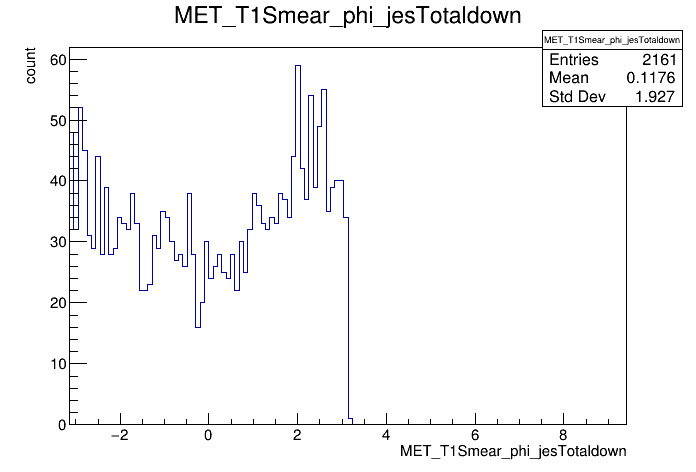

In [22]:
c = ROOT.TCanvas()
histos[branches[-1]].Draw()
c.Draw()

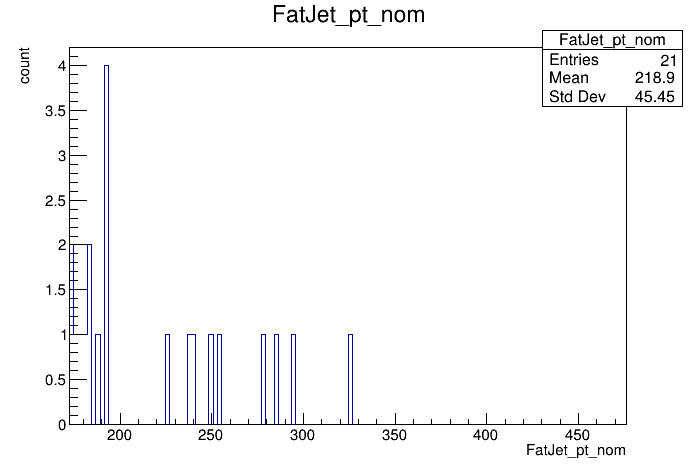

In [17]:
c = ROOT.TCanvas()
df_snap.Draw()
c.Draw()

## Define preselection flow - Data

In [ ]:
#chain = ["root://xrootd-cms.infn.it//store/data/Run2017B/SingleElectron/NANOAOD/02Apr2020-v1/230000/1D3BEA1E-34E5-F04D-B470-5527915AC028.root"]
 #VBS_SSWW_LL_2017

if distributed == True:
    df_data = RDataFrame("Events", chain_data, npartitions=nPartitions, daskclient=client)
else:
    chain_data = ["root://xrootd-cms.infn.it//store/data/Run2017B/SingleElectron/NANOAOD/02Apr2020-v1/230000/1D3BEA1E-34E5-F04D-B470-5527915AC028.root"]
    #chain_data = ["1D3BEA1E-34E5-F04D-B470-5527915AC028.root"]
    df_data = RDataFrame("Events", chain_data).Range(10)

In [ ]:
%%time

df_year_data = df_data.DefinePerSample("Year","GetYear(rdfslot_, rdfsampleinfo_)")
df_sample_data = df_year_data.DefinePerSample("Sample", "GetSample(rdfslot_, rdfsampleinfo_)")

#### MET HLT Filter ####   #### working only for 2017 and 2018 (2016 requires a column that is not present in 2017 nd 2018, i.e. HLT_IsoTkMu24, 
#non c'è nei dati 2017: HLT_Ele32_WPTight_Gsf, lo setto a True dummy
df_METHLTFilter_data = df_sample_data.Define("METHLTFilter", "MET_HLT_Filter(Year, Flag_goodVertices, Flag_HBHENoiseFilter, Flag_HBHENoiseIsoFilter, Flag_EcalDeadCellTriggerPrimitiveFilter, Flag_BadPFMuonFilter, Flag_globalSuperTightHalo2016Filter, HLT_Ele27_WPTight_Gsf, true , HLT_IsoMu24, HLT_IsoMu27, HLT_Mu50, HLT_Ele35_WPTight_Gsf, HLT_Ele32_WPTight_Gsf_L1DoubleEG, HLT_Photon200)")\
                                     .Filter("METHLTFilter == true", "MET HLT Filter")

#### preselection #####
df_preselection_data = df_METHLTFilter_data.Filter("PV_ndof> 4 && abs(PV_z) < 20 && hypot(PV_x, PV_y)<2", "Good vertex")\
                                           .Define("HT_eventHT", "GetEventHT(Jet_pt, Jet_eta, Jet_phi, Jet_mass)")


#### lepSF #####
df_LepSF_data = df_preselection_data.Define("Electron_effSF", "ones(nElectron)")\
                                    .Define("Electron_effSF_errUp", "ones(nElectron)")\
                                    .Define("Electron_effSF_errDown", "ones(nElectron)")\
                                    .Define("Muon_effSF", "ones(nMuon)")\
                                    .Define("Muon_effSF_errUp", "ones(nMuon)")\
                                    .Define("Muon_effSF_errDown", "ones(nMuon)")


#### mht ####
df_mht_data = df_LepSF_data.Define("MHT_pt_phi", "MHT_pt_phi(Electron_pt, Electron_eta, Electron_phi, Electron_mass, Electron_miniPFRelIso_all, Muon_pt, Muon_eta, Muon_phi, Muon_mass, Muon_miniPFRelIso_all, Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_muonIdx1, Jet_muonIdx2, Jet_electronIdx1, Jet_electronIdx2, nJet)")\
                 .Define("MHT_pt", "MHT_pt_phi[0]").Define("MHT_phi", "MHT_pt_phi[1]")\


#### puWeight #####
df_puWeight_data = df_mht_data.Define("puWeight", "1.")\
                              .Define("puWeightUp", "1.")\
                              .Define("puWeightDown", "1.")


#### prefCorr ####
df_prefCorr_data = df_puWeight_data.Define("PrefireWeight", "1.")\
                                   .Define("PrefireWeightUp", "1.")\
                                   .Define("PrefireWeightDown", "1.")

#### ht ####
df_ht_data = df_prefCorr_data.Define("HT_pt", "htProducer(nJet, Jet_pt)")

#### btagSF ##### preselection part2
df_btagSF_data = df_ht_data.Define("Jet_btagSF_deepjet_M", "ones(nJet)")\
                           .Define("Jet_btagSF_deepjet_M_up", "ones(nJet)")\
                           .Define("Jet_btagSF_deepjet_M_down", "ones(nJet)")

#### muonScaleRes ####
df_muonScaleRes_data = df_btagSF_data.Define("muonCorrectedPTs", "muonScaleRes_data(Muon_pt, Muon_eta, Muon_phi, Muon_charge, Year)")\
                                     .Define("Muon_corrected_pt", "getFlattenedMatrixColumn(muonCorrectedPTs, 3, 0)")\
                                     .Define("Muon_correctedUp_pt", "getFlattenedMatrixColumn(muonCorrectedPTs, 3, 1)")\
                                     .Define("Muon_correctedDown_pt", "getFlattenedMatrixColumn(muonCorrectedPTs, 3, 2)")

#### metCorrector and fatJetCorrector #### ####
df_jme_data = df_muonScaleRes_data.Define("jetVars", "myJetVarCalc.produce(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_rawFactor, Jet_area, Jet_jetId, fixedGridRhoFastjetAll, 0, {}, {}, {}, {})")\
                                  .Define("Jet_pt_nom", "jetVars.pt(0)")\
                                  .Define("Jet_mass_nom", "jetVars.mass(0)")\
                                  .Define("fatjetVars", "myFatJetVarCalc.produce(FatJet_pt, FatJet_eta, FatJet_phi, FatJet_mass, FatJet_rawFactor, FatJet_area, FatJet_msoftdrop, FatJet_subJetIdx1, FatJet_subJetIdx2, SubJet_pt, SubJet_eta, SubJet_phi, SubJet_mass, {}, fixedGridRhoFastjetAll, 0 , {}, {}, {}, {}, {}, {}, {}, {})")\
                                  .Define("FatJet_pt_nom", "fatjetVars.pt(0)")\
                                  .Define("FatJet_mass_nom", "fatjetVars.mass(0)")\
                                  .Define("FatJet_msoftdrop_nom", "fatjetVars.msoftdrop(0)")\
                                  .Define("metVars", "myType1METVarCalc.produce(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_rawFactor, Jet_area, Jet_muonSubtrFactor, Jet_neEmEF, Jet_chEmEF, Jet_jetId, fixedGridRhoFastjetAll, 0, {}, {}, {}, {}, RawMET_phi , RawMET_pt, MET_MetUnclustEnUpDeltaX, MET_MetUnclustEnUpDeltaY, CorrT1METJet_rawPt, CorrT1METJet_eta, CorrT1METJet_phi, CorrT1METJet_area, CorrT1METJet_muonSubtrFactor, {}, {})")\
                                  .Define("MET_T1_pt_nom", "metVars.pt(0)")\
                                  .Define("MET_T1_phi_nom", "metVars.phi(0)")\
                                  .Define("metsVars", "myType1SmearMETVarCalc.produce(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_rawFactor, Jet_area, Jet_muonSubtrFactor, Jet_neEmEF, Jet_chEmEF, Jet_jetId, fixedGridRhoFastjetAll, 0, {}, {}, {}, {}, RawMET_phi , RawMET_pt, MET_MetUnclustEnUpDeltaX, MET_MetUnclustEnUpDeltaY, CorrT1METJet_rawPt, CorrT1METJet_eta, CorrT1METJet_phi, CorrT1METJet_area, CorrT1METJet_muonSubtrFactor, {}, {})")\
                                  .Define("MET_T1Smear_pt_nom", "metsVars.pt(0)")\
                                  .Define("MET_T1Smear_phi_nom", "metsVars.phi(0)")
                        
for n,v in enumerate(jetvariations[1:]):
    df_jme_data = df_jme_data.Define("Jet_pt_{}".format(v), "jetVars.pt({})".format(1+n)).Define("Jet_mass_{}".format(v), "jetVars.mass({})".format(1+n))
for n,v in enumerate(fatjetvariations[1:]):
    df_jme_data = df_jme_data.Define("FatJet_pt_{}".format(v), "fatjetVars.pt({})".format(1+n)).Define("FatJet_mass_{}".format(v), "fatjetVars.mass({})".format(1+n)).Define("FatJet_msoftdrop_{}".format(v), "fatjetVars.msoftdrop({})".format(1+n))
for n,v in enumerate(mett1variations[1:]):
    df_jme_data = df_jme_data.Define("MET_T1_pt_{}".format(v), "metVars.pt({})".format(1+n)).Define("MET_T1_phi_{}".format(v), "metVars.phi({})".format(1+n))  
for n,v in enumerate(mett1smearvariations[1:]):
    df_jme_data = df_jme_data.Define("MET_T1Smear_pt_{}".format(v), "metsVars.pt({})".format(1+n)).Define("MET_T1Smear_phi_{}".format(v), "metsVars.phi({})".format(1+n))    


### add dummy columns ####
df_jme_data = df_jme_data.Define("Tau_genPartFlav", "ones(nTau)")\
                         .Define("Jet_partonFlavour", "ones(nJet)")

### book snapshot ###
opts = ROOT.RDF.RSnapshotOptions()
opts.fLazy = True

if distributed == True:
    #df_jme_data_lazy = df_jme_data.Snapshot("testTree", "root://stormgf3.pi.infn.it:1094//store/user/ttedesch/dummy_test/testFile_Data.root", branchlist, opts)
    df_jme_data_lazy = df_jme_data.Count()
else:
    df_jme_data_lazy = df_jme_data.Snapshot("testTree", "testFile_Data.root", branchlist, opts)

## Launch the two computations concurrently and save results

In [ ]:
if distributed == True:
    RunGraphs = ROOT.RDF.Experimental.Distributed.RunGraphs   
else:
    RunGraphs = ROOT.RDF.RunGraphs

proxies = [df_jme_lazy, df_jme_data_lazy]
RunGraphs(proxies)
dfs = [df_.GetValue() for df_ in proxies]

In [ ]:
for k,v in nevents_df.items():
    nevents_df[k] = v.GetValue()
for k,v in gen_weight_df.items():
    gen_weight_df[k] = v.GetValue()
with open('nEventsDict.json', 'w') as fp:
    json.dump(nevents_df, fp)
with open('genWeightDict.json', 'w') as fp:
    json.dump(gen_weight_df, fp)

## Debug

In [41]:
#df_test =  ROOT.RDataFrame("testTree", "testFile_MC.root")
df_test = df_jme
#df_test.Display(["Electron_effSF", "Electron_effSF_errUp", "Electron_effSF_errDown", "Muon_effSF", "Muon_effSF_errUp", "Muon_effSF_errUp"], nRows = 5).Print()
#df_test.Display(["FatJet_pt_jesTotalup"], nRows = 10).Print()
#df_test.Display(["Muon_corrected_pt", "Muon_correctedUp_pt", "Muon_correctedDown_pt"], nRows = 5).Print()
#df_test.Display(["Jet_btagSF_deepjet_M_up","Jet_btagSF_deepjet_M_up", "Jet_btagSF_deepjet_M_down"]).Print()
#df_test.Display(["PrefireWeight" ,"PrefireWeightUp", "PrefireWeightDown"], nRows = 6).Print()
#df_test.Display(["Photon_pt", "Photon_eta", "Photon_jetIdx", "Photon_electronIdx"], nRows = 1).Print()
#df_test.Display(["Electron_pt", "Electron_eta", "Electron_jetIdx", "Electron_photonIdx"], nRows = 1).Print()
#df_test.Display(["Jet_pt", "Jet_eta"], nRows = 1).Print()
#df_test.Display(["MHT_pt" ,"MHT_phi"]).Print()
#df_test.Display(["HT_pt"]).Print()
#df_test.Display(["puWeight" ,"puWeightUp", "puWeightDown"]).Print()
#df_test.Display(["Jet_pt_nom", "Jet_pt_jerup", "Jet_pt_jerdown", "Jet_pt_jesTotalup", "Jet_pt_jesTotaldown"], nRows = 15).Print()
#df_test.Display(["Jet_mass_nom", "Jet_mass_jerup", "Jet_mass_jerdown", "Jet_mass_jesTotalup", "Jet_mass_jesTotaldown"], nRows = 15).Print()
#df_test.Display(["MET_T1_phi_nom", "MET_T1_phi_jerup", "MET_T1_phi_jerdown", "MET_T1_phi_jesTotalup", "MET_T1_phi_jesTotaldown"],  nRows = 15).Print()
#df_test.Display(["MET_T1Smear_pt_nom", "MET_T1Smear_pt_jerup", "MET_T1Smear_pt_jerdown"], nRows = 15).Print()
#df_test.Display(["MET_T1Smear_phi_nom", "MET_T1Smear_phi_jesTotalup", "MET_T1Smear_phi_jesTotaldown"], nRows = 15).Print()
#df_test.Display(["MET_T1Smear_pt_jesTotaldown", "MET_T1Smear_phi_jesTotalup", "MET_T1Smear_phi_jesTotaldown"]).Print()
#df_test.Display(["FatJet_pt_jesTotaldown", "FatJet_mass_jesTotalup", "FatJet_msoftdrop_jesTotaldown"]).Print()
df_test.Display(["FatJet_msoftdrop_nom", "FatJet_msoftdrop_jerup", "FatJet_msoftdrop_jerdown", "FatJet_msoftdrop_jesTotalup", "FatJet_msoftdrop_jesTotaldown"], nRows = 15).Print()
#df_test.Display(["Jet_mass_nom", "Jet_mass_jerup", "Jet_mass_jerdown", "Jet_mass_jesTotalup", "Jet_mass_jesTotaldown"], nRows = 15).Print()

+-----+----------------------+------------------------+--------------------------+-----+
| Row | FatJet_msoftdrop_nom | FatJet_msoftdrop_jerup | FatJet_msoftdrop_jerdown | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 1   |                      |                        |                          | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 2   | 10.0181f             | 10.0556f               | 9.98050f                 | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 3   | 109.517f             | 110.733f               | 108.302f                 | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 5   |                      |                        |                          | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 8   |         

Info in <Print>: Only showing 4 columns out of 6



In [40]:
#df_classic = ROOT.RDataFrame("Events","https://ttedesch.web.cern.ch/ttedesch/testAF/VBS_SSWW_LL_SM_2017/tree_hadd_2.root")
df_classic = ROOT.RDataFrame("Events","https://ttedesch.web.cern.ch/ttedesch/VBS_SSWW_LL_SM_2017_tree_hadd_2_RR2017.root")
#df_test.Display(["ElectronSFs", "Electron_effSF", "MuonSFs", "Muon_effSF"], nRows = 20).Print()
#df_classic.Display(["Electron_effSF", "Electron_effSF_errUp", "Electron_effSF_errDown", "Muon_effSF", "Muon_effSF_errUp", "Muon_effSF_errUp"], nRows = 5).Print()
#df_classic.Display(["FatJet_pt_jesTotalUp"], nRows = 10).Print()
#df_classic.Display(["Muon_corrected_pt", "Muon_correctedUp_pt", "Muon_correctedDown_pt"], nRows = 5).Print()
#df_classic.Display(["Jet_btagSF_deepjet_M_up","Jet_btagSF_deepjet_M_up", "Jet_btagSF_deepjet_M_down"]).Print()
#df_classic.Display(["Jet_btagSF_deepjet_M_up","Jet_btagSF_deepjet_M_up", "Jet_btagSF_deepjet_M_down"]).Print()
#df_classic.Display(["PrefireWeight" ,"PrefireWeight_Up", "PrefireWeight_Down"], nRows = 6).Print()
#df_classic.Display(["Photon_pt", "Photon_eta", "Photon_jetIdx", "Photon_electronIdx"], nRows = 1).Print()
#df_classic.Display(["Electron_pt", "Electron_eta", "Electron_jetIdx", "Electron_photonIdx"], nRows = 1).Print()
#df_classic.Display(["Jet_pt", "Jet_eta"], nRows = 1).Print()
#df_classic.Display(["puWeight" ,"puWeightUp", "puWeightDown"]).Print()
#df_test.Display(["puWeight" ,"puWeightUp", "puWeightDown"]).Print()
#df_classic.Display(["MHT_pt" ,"MHT_phi"]).Print()
#df_classic.Display(["HT_pt"]).Print()
#df_classic.Display(["Jet_pt_jesTotalUp", "Jet_pt_jesTotalDown"]).Print()
#df_classic.Display(["Jet_mass_nom", "Jet_mass_jerUp", "Jet_mass_jerDown", "Jet_mass_jesTotalUp", "Jet_mass_jesTotalDown"], nRows = 20).Print()
#df_classic.Display(["MET_T1_phi", "MET_T1_phi_jerUp", "MET_T1_phi_jerDown", "MET_T1_phi_jesTotalUp", "MET_T1_phi_jesTotalDown"],  nRows = 15).Print()
#df_classic.Display(["MET_T1Smear_pt", "MET_T1Smear_pt_jerUp", "MET_T1Smear_pt_jerDown",], nRows = 15).Print()
#df_classic.Display(["MET_T1Smear_phi", "MET_T1Smear_phi_jesTotalUp", "MET_T1Smear_phi_jesTotalDown"], nRows = 15).Print()
#df_classic.Display(["MET_T1_pt_jesTotalDown", "MET_T1_phi_jesTotalUp", "MET_T1_phi_jesTotalDown"]).Print()
#df_classic.Display(["MET_T1Smear_pt_jesTotalDown", "MET_T1Smear_phi_jesTotalUp", "MET_T1Smear_phi_jesTotalDown"]).Print()
df_classic.Display(["FatJet_msoftdrop_nom", "FatJet_msoftdrop_jerUp", "FatJet_msoftdrop_jerDown", "FatJet_msoftdrop_jesTotalUp", "FatJet_msoftdrop_jesTotalDown"], nRows = 15).Print()
#df_classic.Display(["FatJet_pt_jesTotalDown", "FatJet_mass_jesTotalUp", "FatJet_msoftdrop_jesTotalDown"]).Print()

+-----+----------------------+------------------------+--------------------------+-----+
| Row | FatJet_msoftdrop_nom | FatJet_msoftdrop_jerUp | FatJet_msoftdrop_jerDown | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 0   |                      |                        |                          | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 1   | 10.4631f             | 10.5023f               | 10.4239f                 | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 2   | 126.665f             | 128.071f               | 125.259f                 | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 3   |                      |                        |                          | ... | 
+-----+----------------------+------------------------+--------------------------+-----+
| 4   |         

Info in <Print>: Only showing 4 columns out of 6



In [17]:
#print(df_classic.GetColumnNames())

In [ ]:
'''
df_test =  RDataFrame("testTree", "testFile.root")
#df_test.Display(["ElectronSFs", "Electron_effSF", "MuonSFs", "Muon_effSF"], nRows = 20).Print()
df_test.Display(["Jet_pt", "Jet_eta", "Jet_hadronFlavour", "Jet_btagDeepFlavB"]).Print()
'''

In [38]:
print(df_classic.GetColumnNames())

{ "CaloMET_phi", "CaloMET_pt", "CaloMET_sumEt", "ChsMET_phi", "ChsMET_pt", "ChsMET_sumEt", "CorrT1METJet_area", "CorrT1METJet_eta", "CorrT1METJet_muonSubtrFactor", "CorrT1METJet_phi", "CorrT1METJet_rawPt", "Electron_charge", "Electron_cleanmask", "Electron_convVeto", "Electron_cutBased", "Electron_cutBased_Fall17_V1", "Electron_cutBased_HEEP", "Electron_deltaEtaSC", "Electron_dr03EcalRecHitSumEt", "Electron_dr03HcalDepth1TowerSumEt", "Electron_dr03TkSumPt", "Electron_dr03TkSumPtHEEP", "Electron_dxy", "Electron_dxyErr", "Electron_dz", "Electron_dzErr", "Electron_eCorr", "Electron_eInvMinusPInv", "Electron_effSF", "Electron_effSF_errDown", "Electron_effSF_errUp", "Electron_energyErr", "Electron_eta", "Electron_genPartFlav", "Electron_genPartIdx", "Electron_hoe", "Electron_ip3d", "Electron_isPFcand", "Electron_jetIdx", "Electron_jetPtRelv2", "Electron_jetRelIso", "Electron_lostHits", "Electron_mass", "Electron_miniPFRelIso_all", "Electron_miniPFRelIso_chg", "Electron_mvaFall17V1Iso", "Ele